In [1]:
import pandas as pd

x_train = pd.read_csv('Dataset/x_train_all.csv')
y_train = pd.read_csv('Dataset/y_train_all.csv')

merged_df = pd.concat([x_train, y_train], axis=1)



In [2]:
data = x_train.iloc[1:9690]

x_train.iloc[:1]

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,87.0,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0


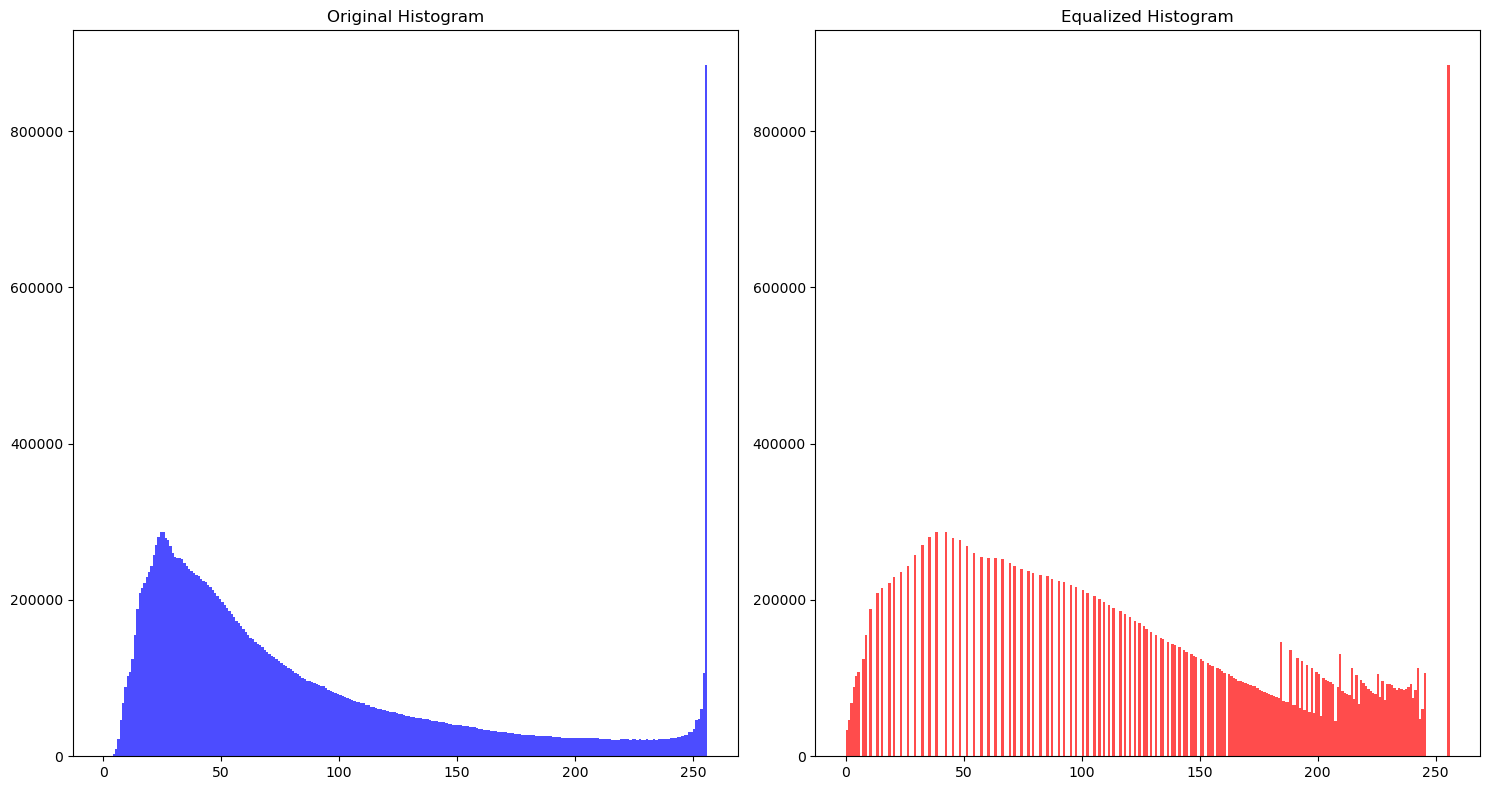

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image_data = np.array(data, dtype=np.uint8)

equalized_image = cv2.equalizeHist(image_data)

plt.figure(figsize=(15, 8))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(equalized_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Equalized Histogram')

plt.tight_layout()
plt.show()

In [4]:
#Contrast Limited Adaptive Histogram Equalization 
def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

def brighten(row, target_mean_brightness=128, max_brightness_adjustment=50):
    current_mean_brightness = np.mean(row)
    brightness_adjustment = target_mean_brightness - current_mean_brightness
    brightness_adjustment = np.clip(brightness_adjustment, -max_brightness_adjustment, max_brightness_adjustment)
    scaling_factor = (current_mean_brightness + brightness_adjustment) / current_mean_brightness
    adjusted_row = row * scaling_factor
    adjusted_row[adjusted_row < 0] = 0
    adjusted_row[adjusted_row > 255] = 255
    return adjusted_row


def apply_gamma_correction(row, gamma=1.8):
    input_shape = row.shape
    row = np.array(row, dtype=np.uint8)
    corrected_row = ((row / 255.0) ** (1 / gamma) * 255).astype(np.uint8)
    corrected_row = corrected_row.reshape(*input_shape) 
    return corrected_row

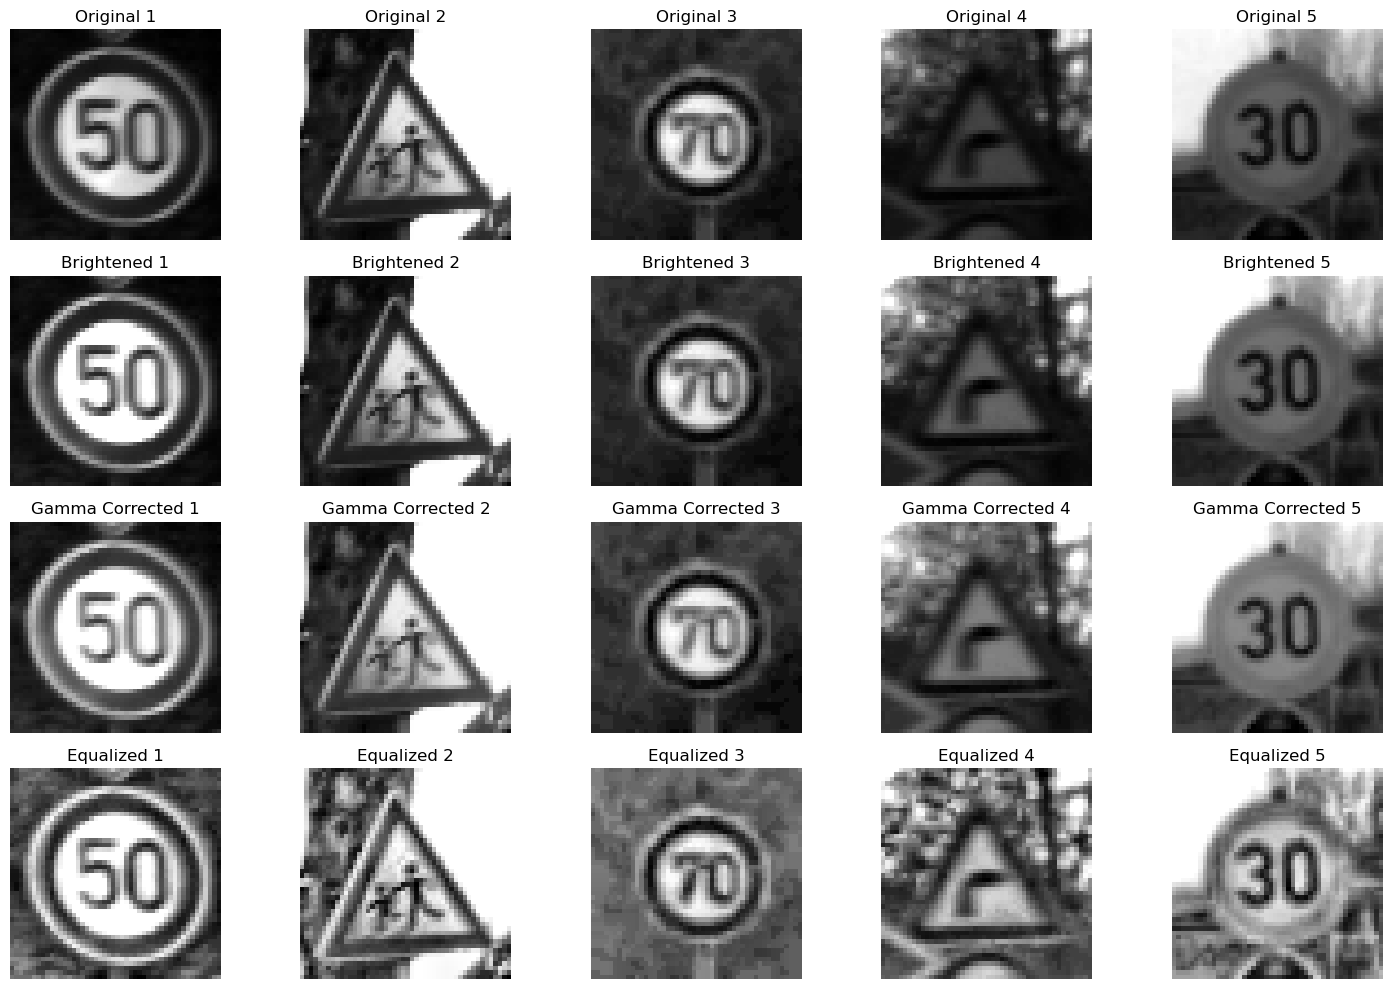

In [5]:

x_copy = x_train.copy()

sample_size = 5
sample_indices = x_copy.sample(sample_size).index


plt.figure(figsize=(15, 10))

for i, idx in enumerate(sample_indices):
    plt.subplot(4, sample_size, i + 1)
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    brightened_image = brighten(x_copy.iloc[idx].values)
    plt.subplot(4, sample_size, sample_size + i + 1)
    brightened_image = brightened_image.reshape(48, 48)
    plt.imshow(brightened_image, cmap='gray')
    plt.title(f'Brightened {i+1}')
    plt.axis('off')

    gamma_image = apply_gamma_correction(brightened_image)
    plt.subplot(4, sample_size, 2*sample_size + i + 1)
    plt.imshow(gamma_image, cmap='gray')
    plt.title(f'Gamma Corrected {i+1}')
    plt.axis('off')

    equalized_image = apply_clahe(gamma_image)
    plt.subplot(4, sample_size, 3*sample_size + i + 1)
    plt.imshow(equalized_image, cmap='gray')
    plt.title(f'Equalized {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [6]:
processed_images = []

sample_size = 5
sample_indices = x_copy.sample(sample_size).index

for i, idx in enumerate(sample_indices):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)

    processed_images.append(equalized_image.flatten())

processed_df_subset = pd.DataFrame(processed_images)
processed_df_subset.shape

(5, 2304)

In [7]:
processed_images = []

for i, idx in enumerate(x_copy.index):
    original_image = x_copy.iloc[idx].values.reshape(48, 48)
    brightened_image = brighten(x_copy.iloc[idx].values).reshape(48, 48)
    gamma_image = apply_gamma_correction(brightened_image)
    equalized_image = apply_clahe(gamma_image)
    processed_images.append(equalized_image.flatten())

processed_df = pd.DataFrame(processed_images)
processed_df.shape

(9690, 2304)

In [8]:
x_train.shape

(9690, 2304)

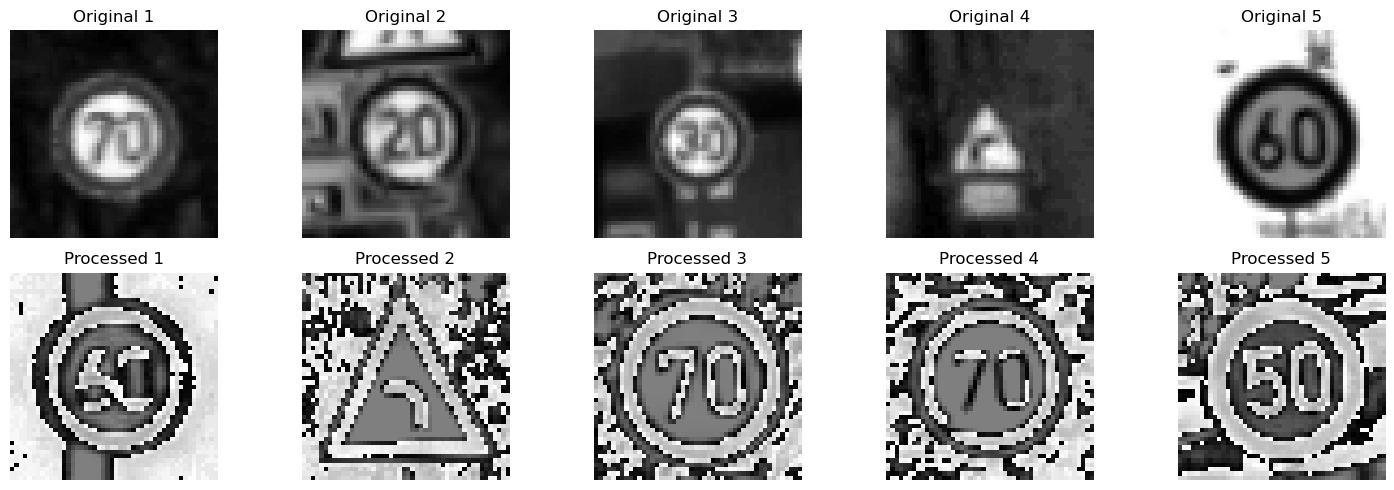

In [9]:

x_train_reset = x_copy.reset_index(drop=True)
sample_size = 5
sample_indices = x_copy.sample(sample_size).index
plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    original_image = x_train_reset.iloc[idx].values.reshape(48, 48)
    processed_image = processed_df_subset.iloc[i].values.reshape(48, 48)

    plt.subplot(2, sample_size, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(2, sample_size, sample_size + i + 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title(f'Processed {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
merged_df.shape

(9690, 2305)

In [12]:
# merged_df.to_csv("merged_df.csv")

In [13]:
# processed_df.to_csv("processed_df.csv")

In [11]:
processed_df.shape

(9690, 2304)

In [12]:
y_train.shape

(9690, 1)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 22

X_train, X_test, Y_train, Y_test = train_test_split(processed_df, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5259717922256621
F1 Score: 0.505946261779949
Confusion Matrix:
 [[ 46 152  55  49  63   4   2   0   0   3]
 [ 11 307 178  55  89   0   0   0   0   0]
 [  5  90 282  18  50   0   0   0   0   0]
 [  1  31  52 217  32   1   1   1   7   5]
 [  1  84  68  52 327   0   0   0   0   0]
 [  0   1   0   0   1  47   3   3   7   5]
 [  1   4  14  20  13   5  67   1  17   5]
 [  0   1   0   0   1   0   0  51   0   0]
 [  0   0   0   0   0   3   2   0 133   7]
 [  0  16  15   9   7   5  29   9  14  52]]


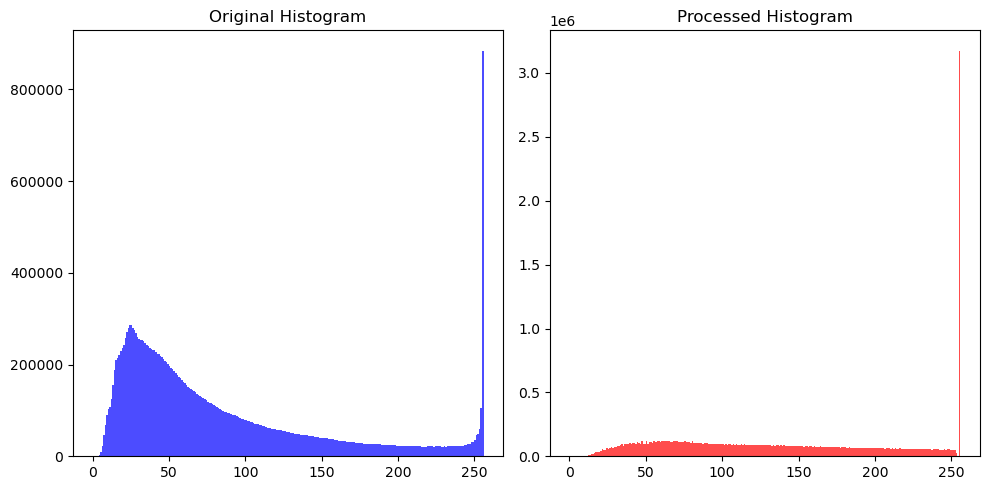

In [15]:
image_data = np.array(data, dtype=np.uint8)

processed_image = apply_clahe(apply_gamma_correction(brighten(image_data)))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_image.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [16]:
# Z normalization to preprocessed data
mean=processed_df.mean()
std=processed_df.std()
processed_df_norm=(processed_df-mean)/std

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 22

X_train_norm, X_test_norm, Y_train_norm, Y_test_norm = train_test_split(processed_df_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_norm, Y_train_norm)

predicted = gnb.predict(X_test_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
accuracy = accuracy_score(predicted, Y_test_norm)
f1 = f1_score(predicted, Y_test_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5259717922256621
F1 Score: 0.505946261779949
Confusion Matrix:
 [[ 46 152  55  49  63   4   2   0   0   3]
 [ 11 307 178  55  89   0   0   0   0   0]
 [  5  90 282  18  50   0   0   0   0   0]
 [  1  31  52 217  32   1   1   1   7   5]
 [  1  84  68  52 327   0   0   0   0   0]
 [  0   1   0   0   1  47   3   3   7   5]
 [  1   4  14  20  13   5  67   1  17   5]
 [  0   1   0   0   1   0   0  51   0   0]
 [  0   0   0   0   0   3   2   0 133   7]
 [  0  16  15   9   7   5  29   9  14  52]]


In [19]:
# Outlier mining to processed data

from sklearn.ensemble import IsolationForest

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(processed_df)

outlier_indices = processed_df.index[outliers == -1]

x_train_no_outliers = processed_df.drop(outlier_indices)
y_train_no_outliers = y_train.loc[x_train_no_outliers.index]

print(x_train_no_outliers.shape)
y_train_no_outliers.shape

(9593, 2304)


(9593, 1)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train_out, X_test_out, Y_train_out, Y_test_out = train_test_split(x_train_no_outliers, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_out, Y_train_out)

predicted = gnb.predict(X_test_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
accuracy = accuracy_score(predicted, Y_test_out)
f1 = f1_score(predicted, Y_test_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5156358582348853
F1 Score: 0.49816528399840854
Confusion Matrix:
 [[ 43 152  45  41  59   1   0   0   0   1]
 [ 13 290 141  46  87   0   0   0   0   1]
 [  3  99 281  28  35   0   0   0   0   1]
 [  1  29  70 201  40   0   2   0   4   8]
 [  2  72  96  55 330   0   1   0   0   0]
 [  0   1   4   0   4  48   2   0   8   4]
 [  0   3  18  21  14   5  61   3  23   5]
 [  0   1   1   0   1   1   3  56   1   1]
 [  0   0   2   0   0   5   3   0 115   5]
 [  0  10  11  20   9   9  36  13  14  59]]


In [30]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 24

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5156358582348853
F1 Score: 0.49816528399840854
Confusion Matrix:
 [[ 43 152  45  41  59   1   0   0   0   1]
 [ 13 290 141  46  87   0   0   0   0   1]
 [  3  99 281  28  35   0   0   0   0   1]
 [  1  29  70 201  40   0   2   0   4   8]
 [  2  72  96  55 330   0   1   0   0   0]
 [  0   1   4   0   4  48   2   0   8   4]
 [  0   3  18  21  14   5  61   3  23   5]
 [  0   1   1   0   1   1   3  56   1   1]
 [  0   0   2   0   0   5   3   0 115   5]
 [  0  10  11  20   9   9  36  13  14  59]]


In [32]:
no_out_processed_df_norm.shape

(9593, 2304)

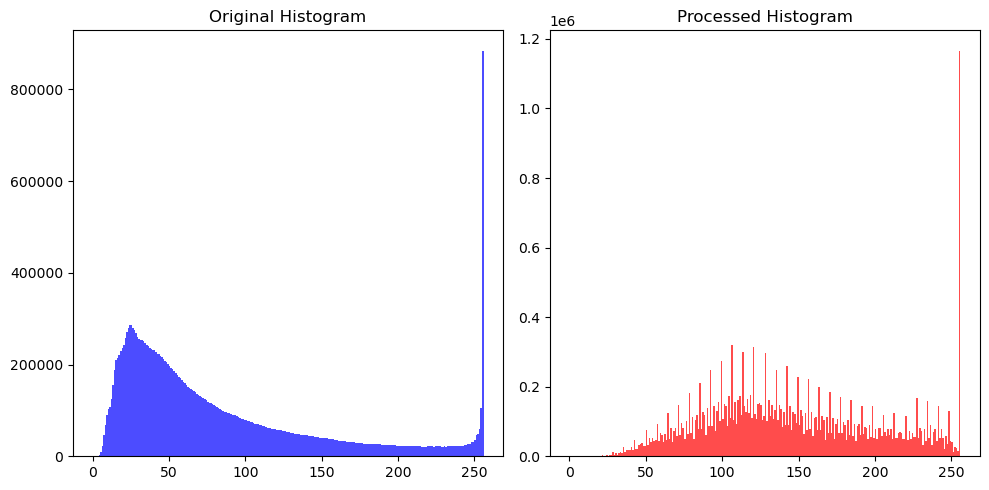

In [25]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [26]:
# Z normalization to outlier mined preprocessed data

mean=x_train_no_outliers.mean()
std=x_train_no_outliers.std()
no_out_processed_df_norm=(x_train_no_outliers-mean)/std

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 26

X_train, X_test, Y_train, Y_test = train_test_split(no_out_processed_df_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

predicted = gnb.predict(X_test)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [28]:
accuracy = accuracy_score(predicted, Y_test)
f1 = f1_score(predicted, Y_test, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.5069492703266157
F1 Score: 0.48815049787586706
Confusion Matrix:
 [[ 40 140  50  56  59   1   0   0   0   1]
 [ 12 272 144  40  98   0   0   0   0   0]
 [  5  84 268  23  50   0   0   0   0   0]
 [  1  28  69 216  53   1   2   2   6   6]
 [  2  85  89  38 338   0   1   0   0   0]
 [  0   0   4   0   0  50   6   4   3   1]
 [  0  12  33  27  23   7  69   4  18   6]
 [  0   0   1   0   0   2   1  51   0   0]
 [  0   0   2   0   0   3   5   0 106   7]
 [  0  12  21  15   4   8  18   7  19  49]]


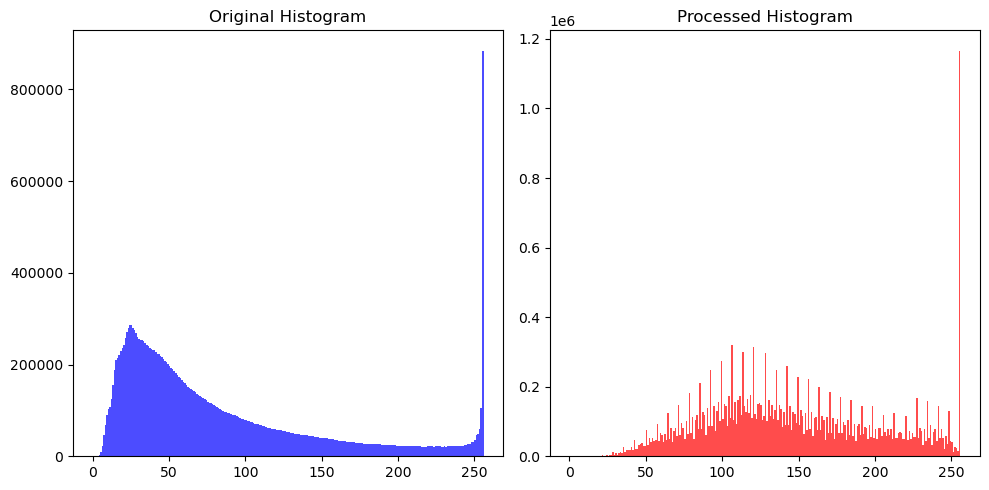

In [38]:
image_data = np.array(data, dtype=np.uint8)
processed_data = np.array(x_train_no_outliers.iloc[1:9593], dtype=np.uint8)


plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist(image_data.ravel(), bins=256, range=(0, 256), color='b', alpha=0.7)
plt.title('Original Histogram')

plt.subplot(122)
plt.hist(processed_data.ravel(), bins=256, range=(0, 256), color='r', alpha=0.7)
plt.title('Processed Histogram')

plt.tight_layout()
plt.show()

In [84]:
y_train=y_train.rename(columns={'0':'label'})

In [85]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [86]:
merged_df = pd.concat([x_train, y_train], axis=1)



In [87]:
merged_df

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,label
0,78.0,77.0,76.0,82.0,87.0,92.0,104.0,119.0,117.0,120.0,...,79.0,72.0,76.0,83.0,95.0,99.0,98.0,95.0,94.0,0
1,73.0,75.0,79.0,78.0,76.0,75.0,89.0,107.0,133.0,125.0,...,93.0,85.0,77.0,69.0,73.0,83.0,100.0,101.0,101.0,0
2,72.0,75.0,79.0,77.0,81.0,89.0,105.0,109.0,86.0,90.0,...,95.0,88.0,80.0,73.0,71.0,74.0,80.0,89.0,95.0,0
3,67.0,70.0,74.0,80.0,93.0,107.0,110.0,96.0,69.0,100.0,...,92.0,87.0,82.0,77.0,72.0,70.0,72.0,81.0,88.0,0
4,74.0,74.0,73.0,72.0,77.0,87.0,104.0,109.0,84.0,83.0,...,98.0,99.0,100.0,99.0,89.0,78.0,66.0,68.0,72.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,247.0,220.0,254.0,213.0,129.0,208.0,254.0,255.0,255.0,255.0,...,29.0,27.0,26.0,25.0,23.0,22.0,26.0,26.0,27.0,9
9686,151.0,118.0,254.0,255.0,255.0,255.0,254.0,254.0,254.0,252.0,...,31.0,30.0,30.0,30.0,30.0,29.0,26.0,28.0,27.0,9
9687,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,49.0,42.0,36.0,33.0,36.0,39.0,31.0,39.0,43.0,9
9688,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,27.0,26.0,27.0,35.0,28.0,27.0,26.0,26.0,24.0,9


In [88]:
from sklearn.decomposition import PCA

df = merged_df
target_column = 'label'
features = df.drop(target_column, axis=1)
target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(features)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca)

Transformed DataFrame:
              PC1          PC2          PC3          PC4         PC5  \
0     1833.678654  -327.432280  -247.743190  -608.483725 -348.793581   
1     1859.007019  -349.977157  -192.222284  -595.379147 -443.962323   
2     1764.509881  -388.614024  -133.034248  -686.073427 -473.539393   
3     1676.632914  -400.702911  -100.745308  -732.746033 -495.178378   
4     1902.532764  -338.990792   -62.149332  -692.201419 -284.736489   
...           ...          ...          ...          ...         ...   
9685   987.795453  1450.984446 -1503.450258 -1658.624173 -413.021050   
9686  1017.324304  1511.469231 -1452.548502 -1577.032597 -653.548398   
9687   985.864551  1719.211492 -1749.455042 -1361.267595   28.937437   
9688  1180.694571  1818.178520 -1816.040253 -1798.650930 -378.454307   
9689   564.088760  1545.222780  -854.697719 -1612.762413 -809.463745   

             PC6         PC7          PC8         PC9        PC10        PC11  \
0     651.336694  303.656310   

In [89]:
df_pca_top5 = df_pca.iloc[:, :5]
df_pca_top10 = df_pca.iloc[:, :10]
df_pca_top20 = df_pca.iloc[:, :20]


In [90]:
target

0       0
1       0
2       0
3       0
4       0
       ..
9685    9
9686    9
9687    9
9688    9
9689    9
Name: label, Length: 9690, dtype: int64

In [91]:

df_pca_top5

,PC1,PC2,PC3,PC4,PC5
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793581
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962323
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539393
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178378
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736489
...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624173,-413.021050
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548398
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937437
9688,1180.694571,1818.178520,-1816.040253,-1798.650930,-378.454307


In [92]:

df_pca_top10

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793581,651.336694,303.656310,-10.808849,-408.735804,-79.938083
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962323,680.431306,207.689967,5.860301,-543.226751,-130.360165
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539393,771.513306,156.383394,138.760620,-385.597266,-246.733899
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178378,677.334761,92.548564,214.775936,-312.437054,-322.254762
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736489,617.853676,387.861548,-36.146758,-536.265558,51.230537
...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624173,-413.021050,-330.777666,181.004942,-1054.855887,903.457253,-37.740350
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548398,-414.617192,-148.818773,-821.675541,789.395975,71.776015
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937437,290.977615,280.584270,-954.102977,352.115500,-86.527021
9688,1180.694571,1818.178520,-1816.040253,-1798.650930,-378.454307,-145.034626,361.183191,-795.637171,375.357581,-119.637784


In [93]:

df_pca_top20


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,1833.678654,-327.432280,-247.743190,-608.483725,-348.793581,651.336694,303.656310,-10.808849,-408.735804,-79.938083,400.220498,-535.118034,92.603708,-329.384243,-155.302516,-113.234577,160.000111,189.850927,-140.579491,-72.189701
1,1859.007019,-349.977157,-192.222284,-595.379147,-443.962323,680.431306,207.689967,5.860301,-543.226751,-130.360165,357.894617,-594.575120,123.166843,-213.321944,-84.029890,-148.517142,238.240396,178.486058,82.145547,-10.282607
2,1764.509881,-388.614024,-133.034248,-686.073427,-473.539393,771.513306,156.383394,138.760620,-385.597266,-246.733899,345.032269,-392.849150,60.508182,-147.913377,-172.114123,-89.871695,155.155828,298.116810,210.485857,-21.409294
3,1676.632914,-400.702911,-100.745308,-732.746033,-495.178378,677.334761,92.548564,214.775936,-312.437054,-322.254762,328.966027,-277.296945,61.220863,-119.384738,-247.423571,-44.945349,93.432288,280.116565,249.492700,-255.213441
4,1902.532764,-338.990792,-62.149332,-692.201419,-284.736489,617.853676,387.861548,-36.146758,-536.265558,51.230537,347.808009,-250.338681,206.594620,-249.660890,-64.772020,-205.932580,115.988815,210.753063,-13.216449,329.823450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,987.795453,1450.984446,-1503.450258,-1658.624173,-413.021050,-330.777666,181.004942,-1054.855887,903.457253,-37.740350,-247.937484,49.285866,200.343949,-507.191745,40.714345,-148.263505,357.750195,-117.428153,-181.679006,295.715363
9686,1017.324304,1511.469231,-1452.548502,-1577.032597,-653.548398,-414.617192,-148.818773,-821.675541,789.395975,71.776015,-364.852116,-27.923897,618.412897,-114.312041,-39.021587,-202.622435,184.505216,1.077556,88.870676,83.641457
9687,985.864551,1719.211492,-1749.455042,-1361.267595,28.937437,290.977615,280.584270,-954.102977,352.115500,-86.527021,68.028003,18.542669,541.014543,229.345198,-89.415967,-478.920996,247.637549,408.092747,231.116336,283.690569
9688,1180.694571,1818.178520,-1816.040253,-1798.650930,-378.454307,-145.034626,361.183191,-795.637171,375.357581,-119.637784,179.089363,-82.396997,784.785559,21.894499,-34.948707,-389.689723,412.496495,544.124390,248.150764,58.424463


In [128]:
#Unprocessed data PCA applied top 5 seed 22
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 20

X_train_5, X_test_5, Y_train_5, Y_test_5= train_test_split(df_pca_top5, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5, Y_train_5)

predicted = gnb.predict(X_test_5)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [129]:
accuracy = accuracy_score(predicted, Y_test_5)
f1 = f1_score(predicted, Y_test_5, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3402132782937736
F1 Score: 0.36797210679919823
Confusion Matrix:
 [[  4   4   5   2   1   0   0   0   0   0]
 [ 28 283 107  39  43   2   4   4  46   6]
 [ 12 155 191  19  89  18   0  18  13   5]
 [  0  23  60  95  40   2  23  11   8   8]
 [  7 199 298 245 393  40  88  32  81  44]
 [  0   0   0   1   0   0   1   1   1   0]
 [  0   3   4   2   6   0   3   0   0   0]
 [  1   0   1   0   0   0   0   0   0   0]
 [  0  23   8   9   7   0   3   5  20   8]
 [  0   4   0   1   0   0   0   0   0   0]]


In [158]:
#Unprocessed data PCA applied top 10 seed 24
seed_value = 24

X_train_10, X_test_10, Y_train_10, Y_test_10= train_test_split(df_pca_top10, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10, Y_train_10)

predicted = gnb.predict(X_test_10)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [159]:
accuracy = accuracy_score(predicted, Y_test_10)
f1 = f1_score(predicted, Y_test_10, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.38837289301685585
F1 Score: 0.4021382359007353
Confusion Matrix:
 [[ 11   7   6   5   1   0   0   1   1   0]
 [ 25 297 120  44  54   2   0  10  16  11]
 [  9 110 161  22  86   1   0   1   2   6]
 [  1  17  52  89  50   0   4   3   0   0]
 [ 17 194 299 237 397   2   6   1   2  10]
 [  0   4   7   2   2  35  37  10  42  14]
 [  0  18  22  22  12   5  54   9  33   2]
 [  0   1  11   1   0   0   1  29  13   8]
 [  0  14   2   5   1   4   0   5  45   3]
 [  0   5   1   1   0   1  11   4  10  11]]


In [160]:
#Unprocessed data PCA applied top 20 seed 22
seed_value = 24

X_train_20, X_test_20, Y_train_20, Y_test_20= train_test_split(df_pca_top20, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20, Y_train_20)

predicted = gnb.predict(X_test_20)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [161]:
accuracy = accuracy_score(predicted, Y_test_20)
f1 = f1_score(predicted, Y_test_20, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.35294117647058826
F1 Score: 0.3479638743672782
Confusion Matrix:
 [[ 10  11   7   0   0   0   0   0   1   1]
 [ 23 301 123  72  62   1   1  10   4  10]
 [  6 103 167  12  69   0   0   0   2   2]
 [  6  40  62  77  66   0   1   1   0   2]
 [ 17 146 231 131 259   0   2   0   0   5]
 [  0   0   1   0   1  24  14   5  25   7]
 [  1  62  85 133 145  13  82  10  40  11]
 [  0   0   4   0   0   6   3  34  26  11]
 [  0   0   0   2   0   4   0   9  60   4]
 [  0   4   1   1   1   2  10   4   6  12]]


In [130]:
processed_df.shape

(9690, 2304)

In [132]:
y_train.shape


(9690, 1)

In [133]:
y_train

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [178]:

df = processed_df
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro)

Transformed DataFrame:
             PC1          PC2         PC3         PC4         PC5         PC6  \
0     507.222514  -412.955243 -333.712985 -204.957635    6.254352 -318.696771   
1     601.146901  -775.856881 -351.069800  -70.146907   78.429615 -470.981771   
2     469.397041 -1218.019950 -166.549473 -112.313713  196.134061   65.225646   
3     383.748952 -1025.016473 -515.895001  -71.307056  175.722738   34.582919   
4     488.412474  -457.776167  115.310324 -227.767583  121.450038 -113.892000   
...          ...          ...         ...         ...         ...         ...   
9685 -165.739487  -172.011893 -261.104162 -119.584800 -179.620239   65.649994   
9686 -278.767316  -166.934721  -28.270586 -105.266987 -288.702524 -206.018508   
9687 -266.906332   -19.714209 -248.170776   30.395420 -270.241136  -31.580048   
9688 -360.637699  -157.863227 -209.848500  -57.870218 -161.889145  117.436102   
9689 -167.979242   -97.059935 -294.250890   49.314887  -86.908663   20.305514   

    

In [179]:
df_pca_top5_pro = df_pca_pro.iloc[:, :5]
df_pca_top10_pro = df_pca_pro.iloc[:, :10]
df_pca_top20_pro = df_pca_pro.iloc[:, :20]

In [180]:
#processed data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro, X_test_5_pro, Y_train_5_pro, Y_test_5_pro= train_test_split(df_pca_top5_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro, Y_train_5_pro)

predicted = gnb.predict(X_test_5_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [181]:
accuracy = accuracy_score(predicted, Y_test_5_pro)
f1 = f1_score(predicted, Y_test_5_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.34502923976608185
F1 Score: 0.3732352857787562
Confusion Matrix:
 [[  0   1   0   0   0   0   0   0   0   0]
 [ 44 424 317 132 207   5   8   7  26   8]
 [ 17 146 169  45 120   6   2   2   8   6]
 [  2  23  29  82  58   8   5   0   0   5]
 [  5  52 105 132 178   8  10   2   0   2]
 [  0   0   0   7   7   2   1   1   4   0]
 [  0   6   9   9   5   4  20   2   9   4]
 [  0   0   0   0   0   0   0   0   0   0]
 [  3  31  29  10  19  32  51  43 110  42]
 [  1   1   1   0   2   5   7   5   1  18]]


In [182]:
#processed data PCA applied top 10 seed 24
seed_value = 24

X_train_10_pro, X_test_10_pro, Y_train_10_pro, Y_test_10_pro= train_test_split(df_pca_top10_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro, Y_train_10_pro)

predicted = gnb.predict(X_test_10_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [183]:
accuracy = accuracy_score(predicted, Y_test_10_pro)
f1 = f1_score(predicted, Y_test_10_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.37014103887168903
F1 Score: 0.39075295865433785
Confusion Matrix:
 [[  2   1   1   3   0   0   0   0   0   0]
 [ 41 428 289 137 192   2   1   5   9   4]
 [  9 118 202  38 116   0   7   2   2   1]
 [  4  28  33 112  83   4  13   0   8   1]
 [  7  64 126 113 189   5   1   1   1   6]
 [  0   1   0   8   5   3   9   3   5   2]
 [  0   5   5  12  10   5  16   7  17   4]
 [  0   0   0   0   0   2   8   6   9   7]
 [  0  18  23   5   6  24  44  40 108  30]
 [  0   4   2   0   2   5  14   9   5  10]]


In [188]:
#processed data PCA applied top 20 seed 22
seed_value = 25

X_train_20_pro, X_test_20_pro, Y_train_20_pro, Y_test_20_pro= train_test_split(df_pca_top20_pro, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro, Y_train_20_pro)

predicted = gnb.predict(X_test_20_pro)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [189]:
accuracy = accuracy_score(predicted, Y_test_20_pro)
f1 = f1_score(predicted, Y_test_20_pro, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_pro)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3928448572411421
F1 Score: 0.4034455977226921
Confusion Matrix:
 [[ 10  25  14  10   4   0   0   0   0   0]
 [ 39 389 267 106 182   2   4   0   2   5]
 [  7 143 196  30 116   6   2   1   3   6]
 [  4  34  58 147  86   1   0   0   0   0]
 [ 12  75 103 100 198   5   3   0   1   2]
 [  0   2   0   1   0  15   9   3  13   4]
 [  0   6   9  16   5   7  37   5  16  12]
 [  0   2   1   0   0   6   4  24   7   8]
 [  0   4   9   5   3  26  40  24 113  35]
 [  0   4   2   2   2   2   5   5   3  13]]


In [190]:
processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,1.037172,0.953635,0.941405,1.435282,1.495710,1.488494,-1.253086,-0.894382,-1.149144,-1.027909,...,-1.361106,-1.329408,0.789658,1.006981,1.236493,-1.129708,-0.901115,-0.942055,-1.198383,-1.242128
1,1.534608,-1.209099,-0.948240,-1.021055,-1.379870,1.326375,-1.345859,-0.952095,-0.362478,-0.452566,...,-1.393682,-1.254136,1.190876,0.854851,0.467744,0.734969,-1.392255,-0.645115,-0.600329,-0.630729
2,1.120078,1.362800,1.505994,1.435282,1.414871,-1.441223,-1.090734,-1.113691,0.944775,1.062114,...,-1.285095,-1.254136,1.234250,0.985248,0.738430,0.659519,0.999383,-1.164760,-0.824599,-0.630729
3,0.788453,1.035468,1.264027,1.354558,-1.287482,-1.035926,-1.044347,1.379510,0.389481,1.473073,...,-0.829030,1.262117,1.071595,0.952649,0.976634,0.810418,0.828552,1.168339,-0.974113,-0.707154
4,1.285890,1.280967,1.183372,1.112384,1.276289,1.465334,-1.090734,-1.032893,0.944775,0.815538,...,-1.502269,1.186845,-1.422459,-1.155427,-1.080580,-1.312942,-1.413609,0.648694,0.777331,1.006945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.101517,0.111922,0.111805,0.120623,-0.802444,0.029425,0.057333,0.029026,0.042423,0.134519,...,0.734621,0.584664,0.464347,0.485395,0.543536,0.487064,0.508243,1.019869,1.001602,1.083370
9686,-0.147201,-0.718100,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,1.103817,0.810482,0.724596,0.778787,0.846705,0.885867,0.817875,0.722929,0.852088,0.777670
9687,0.101517,0.111922,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,0.973513,-1.329408,1.169188,0.930916,0.738430,1.122994,-1.402932,0.945634,-1.273140,-1.165703
9688,0.101517,0.111922,0.111805,0.120623,0.040597,0.029425,0.057333,0.029026,0.042423,0.134519,...,1.201545,0.509392,0.431816,0.594059,-1.492022,0.842753,0.860582,0.945634,0.926845,0.777670


In [191]:

df = processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_pro_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_pro_norm)

Transformed DataFrame:
           PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0     5.455751  -5.582999 -4.202681 -2.003815  3.721633  3.680517  5.346345   
1     6.363424  -9.976532 -4.595386  0.209028  4.397259  5.012829  6.561285   
2     4.796055 -14.563298 -1.130367  1.679940 -2.981043  2.415352  6.805577   
3     3.707835 -12.631758 -5.448036  1.336659 -1.333613  2.280753  4.350324   
4     5.274801  -5.036837  1.114490 -2.914998  0.282900  2.359543  1.770996   
...        ...        ...       ...       ...       ...       ...       ...   
9685 -1.781285  -1.801299 -3.115300 -2.102824  0.984144 -1.513919 -0.173172   
9686 -2.907313  -2.124436 -0.753824 -2.283548  4.332564 -0.442894  1.702674   
9687 -2.759290  -0.442557 -3.247170 -0.402646  2.653219 -1.649891 -0.007705   
9688 -3.885945  -1.823350 -2.680377 -0.659003  0.879248 -1.660834  0.552259   
9689 -1.741855  -1.298660 -3.490388 -0.024324  0.897770 -0.531985 -0.610261   

           PC8       PC9    

In [193]:
df_pca_top5_norm = df_pca_pro_norm.iloc[:, :5]
df_pca_top1_norm = df_pca_pro_norm.iloc[:, :10]
df_pca_top20_norm= df_pca_pro_norm.iloc[:, :20]


In [194]:
#processed normalized data PCA applied top 5 seed 25
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

seed_value = 25

X_train_5_pro_norm, X_test_5_pro_norm, Y_train_5_pro_norm, Y_test_5_pro_norm= train_test_split(df_pca_top5_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_pro_norm, Y_train_5_pro_norm)

predicted = gnb.predict(X_test_5_pro_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [195]:
accuracy = accuracy_score(predicted, Y_test_5_pro_norm)
f1 = f1_score(predicted, Y_test_5_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.35122119023047815
F1 Score: 0.37546400426330956
Confusion Matrix:
 [[  0   1   2   0   0   0   0   0   0   0]
 [ 47 387 282 101 170   3   6   2  21   5]
 [ 15 172 207  67 160   8   6   1   6   6]
 [  2  22  31 123  82   6   3   0   0   3]
 [  5  58  94 114 156   7  14   2   0   2]
 [  0   0   0   0   3   0   0   0   0   0]
 [  0   8   7   4   3   9  11   3   8   9]
 [  0   1   2   0   0   0   2   1   1   1]
 [  1  27  32   6  21  34  52  47 120  43]
 [  2   8   2   2   1   3  10   6   2  16]]


In [214]:
#processed normalized data PCA applied top 10 seed 24
seed_value =20

X_train_10_pro_norm, X_test_10_pro_norm, Y_train_10_pro_norm, Y_test_10_pro_norm= train_test_split(df_pca_top1_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_pro_norm, Y_train_10_pro_norm)

predicted = gnb.predict(X_test_10_pro_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [215]:
accuracy = accuracy_score(predicted, Y_test_10_pro_norm)
f1 = f1_score(predicted, Y_test_10_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3804609563123495
F1 Score: 0.3967916507777613
Confusion Matrix:
 [[  1   7   2   0   0   0   0   0   0   0]
 [ 30 409 271 104 139   1   2   1   5   1]
 [  6 151 203  51 141   2   8   1   3   8]
 [  4  28  38 115  85   8   5   0   2   0]
 [ 10  76 132 128 194   6   6   1   1   3]
 [  0   1   1   5   0   5   2   2   1   1]
 [  0   3   3   6   7   2  24   5   9   9]
 [  0   2   1   0   0   4  11  17  14   9]
 [  0  16  21   3  12  26  40  38 121  23]
 [  1   1   2   1   1   8  24   6  13  17]]


In [222]:
#processed normalized data PCA applied top 20 seed 22
seed_value = 25

X_train_20_pro_norm, X_test_20_pro_norm, Y_train_20_pro_norm, Y_test_20_pro_norm= train_test_split(df_pca_top20_norm, y_train, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_pro_norm, Y_train_20_pro_norm)

predicted = gnb.predict(X_test_20_pro_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [223]:
accuracy = accuracy_score(predicted, Y_test_20_pro_norm)
f1 = f1_score(predicted, Y_test_20_pro_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_pro_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.40522875816993464
F1 Score: 0.4129715101493067
Confusion Matrix:
 [[ 15  31  14   5   3   0   0   0   0   0]
 [ 34 372 264  87 176   2   2   3   2   2]
 [  5 158 207  35 114   2   0   2   5   8]
 [  6  30  73 180  88   2   0   0   0   0]
 [ 12  79  93  92 205   7   2   1   0   0]
 [  0   0   0   0   0  14  12   4  11   6]
 [  0   7   5  15   7   8  32   4  13   6]
 [  0   2   0   1   1   6   6  20   7  10]
 [  0   4   2   1   2  26  42  23 113  33]
 [  0   1   1   1   0   3   8   5   7  20]]


In [224]:
x_train_no_outliers

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,78,71,71,113,125,125,-114,-81,-104,-100,...,-115,-121,83,104,124,-93,-74,-86,-107,-107
1,120,-114,-93,-100,-124,111,-122,-86,-36,-51,...,-118,-114,120,90,53,80,-120,-58,-51,-51
2,85,106,120,113,118,-128,-100,-100,77,78,...,-108,-114,124,102,78,73,104,-107,-72,-51
3,57,78,99,106,-116,-93,-96,116,29,113,...,-66,120,109,99,100,87,88,113,-86,-58
4,99,99,92,85,106,123,-100,-93,77,57,...,-128,113,-121,-95,-90,-110,-122,64,78,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,-1,-1,-1,-1,-74,-1,-1,-1,-1,-1,...,78,57,53,56,60,57,58,99,99,106
9686,-22,-72,-1,-1,-1,-1,-1,-1,-1,-1,...,112,78,77,83,88,94,87,71,85,78
9687,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,100,-121,118,97,78,116,-121,92,-114,-100
9688,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,121,50,50,66,-128,90,91,92,92,78


In [225]:
no_out_processed_df_norm

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,1.038875,0.955074,0.943230,1.440357,1.500832,1.492043,-1.259604,-0.899387,-1.155317,-1.034003,...,-1.363331,-1.334650,0.791198,1.009881,1.238887,-1.133158,-0.903264,-0.944822,-1.201934,-1.247726
1,1.538203,-1.215279,-0.952491,-1.025075,-1.385880,1.329316,-1.352741,-0.957326,-0.365586,-0.456524,...,-1.395993,-1.259165,1.193549,0.857386,0.468196,0.736317,-1.395557,-0.647241,-0.602494,-0.634696
2,1.122096,1.365681,1.509634,1.440357,1.419679,-1.448658,-1.096614,-1.119555,0.946761,1.063777,...,-1.287119,-1.259165,1.237047,0.988096,0.739566,0.660674,1.001698,-1.168007,-0.827284,-0.634696
3,0.789210,1.037195,1.266889,1.359333,-1.293134,-1.041841,-1.050045,1.383409,0.389304,1.476262,...,-0.829845,1.264196,1.073931,0.955419,0.978372,0.811961,0.830466,1.170126,-0.977144,-0.711325
4,1.288539,1.283559,1.185974,1.116262,1.280561,1.468796,-1.096614,-1.038441,0.946761,0.816287,...,-1.504868,1.188711,-1.427170,-1.157724,-1.084041,-1.316863,-1.416961,0.649360,0.778359,1.007349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,0.099661,0.110396,0.110962,0.120830,-0.806219,0.027504,0.055960,0.027637,0.040893,0.132740,...,0.737951,0.584830,0.464967,0.487042,0.544180,0.487775,0.509405,1.021335,1.003149,1.083978
9686,-0.150003,-0.722550,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,1.108125,0.811285,0.725952,0.781139,0.848114,0.887604,0.819764,0.723755,0.853289,0.777463
9687,0.099661,0.110396,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,0.977475,-1.334650,1.171800,0.933634,0.739566,1.125341,-1.406259,0.946940,-1.276864,-1.171097
9688,0.099661,0.110396,0.110962,0.120830,0.040086,0.027504,0.055960,0.027637,0.040893,0.132740,...,1.206112,0.509345,0.432344,0.595967,-1.496524,0.844380,0.862572,0.946940,0.928219,0.777463


In [232]:
df = x_train_no_outliers
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out)

Transformed DataFrame:
             PC1          PC2         PC3         PC4         PC5         PC6  \
0     508.573404  -413.546915 -345.760832 -217.189988  -14.252215 -316.258123   
1     603.268544  -775.609406 -369.072406  -87.124105   58.100743 -481.629543   
2     472.832900 -1222.350636 -195.194596  -92.428573  186.235441   46.681643   
3     386.775992 -1023.534712 -541.237835  -58.545330  165.839746   20.887353   
4     491.524420  -465.825172  103.200875 -224.526906  125.975139 -116.717431   
...          ...          ...         ...         ...         ...         ...   
9588 -165.170528  -174.559835 -270.945970 -102.657627 -190.777300   71.722237   
9589 -277.997320  -171.163973  -38.357529  -99.748085 -297.773526 -203.688425   
9590 -266.733336   -20.566406 -253.186283   42.339489 -277.363890  -32.862308   
9591 -359.983244  -160.548750 -219.771130  -40.039820 -169.802490  116.035144   
9592 -167.067795   -98.120747 -302.918677   62.696689  -90.100870   11.005893   

    

In [233]:
df_pca_top5_out = df_pca_out.iloc[:, :5]
df_pca_top10_out = df_pca_out.iloc[:, :10]
df_pca_top20_out = df_pca_out.iloc[:, :20]

In [234]:
y_train_no_outliers=y_train_no_outliers.rename(columns={'0':'label'})
y_train_no_outliers

,label
0,0
1,0
2,0
3,0
4,0
...,...
9685,9
9686,9
9687,9
9688,9


In [245]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out, X_test_5_out, Y_train_5_out, Y_test_5_out= train_test_split(df_pca_top5_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out, Y_train_5_out)

predicted = gnb.predict(X_test_5_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [246]:
accuracy = accuracy_score(predicted, Y_test_5_out)
f1 = f1_score(predicted, Y_test_5_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3578874218207088
F1 Score: 0.38850006850263386
Confusion Matrix:
 [[  0   2   0   0   0   0   0   0   0   0]
 [ 28 444 297 148 204   2   7   2  17   7]
 [ 15 135 187  41 119   5   9   3   9   5]
 [  0  26  35  80  51   7  12   1   4   4]
 [  8  46 119 126 175   9   6   1   5   1]
 [  0   2   0   5   3   0   7   3   6   0]
 [  0   5   8   3   3   2   8   5   7   2]
 [  0   0   0   0   0   0   0   0   0   0]
 [  1  25  33   5  14  26  51  48 117  37]
 [  1   0   0   0   2   4  12   7   5  19]]


In [260]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out, X_test_10_out, Y_train_10_out, Y_test_10_out= train_test_split(df_pca_top10_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out, Y_train_10_out)

predicted = gnb.predict(X_test_10_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [261]:
accuracy = accuracy_score(predicted, Y_test_10_out)
f1 = f1_score(predicted, Y_test_10_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.36935371785962473
F1 Score: 0.3938154592009895
Confusion Matrix:
 [[  0   8   3   0   0   0   0   0   0   0]
 [ 51 420 287 158 197   2   3   5  11   1]
 [ 10 134 192  28 120   2  10   0   2   4]
 [  4  28  40 105  66   7   9   0   7   3]
 [  7  71 132  95 189   8   3   0   0   4]
 [  0   0   0   7   1   2   4   0   2   1]
 [  0  14   1   2   8   7  17   8  10   8]
 [  0   0   0   0   0   2   1   3   2   0]
 [  0  11  14   3   3  35  29  44 118  36]
 [  0   1   2   0   1   7  18   8   5  17]]


In [269]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out, X_test_20_out, Y_train_20_out, Y_test_20_out= train_test_split(df_pca_top20_out, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out, Y_train_20_out)

predicted = gnb.predict(X_test_20_out)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [270]:
accuracy = accuracy_score(predicted, Y_test_20_out)
f1 = f1_score(predicted, Y_test_20_out, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_out)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3822098679638638
F1 Score: 0.39350436470027933
Confusion Matrix:
 [[  9  30  11   5   8   0   0   0   0   0]
 [ 41 397 264 131 188   4   6   2   6   4]
 [  9 136 199  37 102   1   8   1   2   5]
 [  3  35  62 122  99   1   3   0   2   1]
 [ 10  70 123  91 179   6   5   0   0   5]
 [  0   0   0   1   1  17   8   3   9   4]
 [  0   5   1   6   4   5  29  11  10  11]
 [  0   6   1   1   0   6   5  19   9   2]
 [  0   4   8   3   1  30  18  24 112  25]
 [  0   4   2   1   3   2  12   8   7  17]]


In [272]:
df = no_out_processed_df_norm
target_column = 'label'
# features = df.drop(target_column, axis=1)
# target = df[target_column]

pca = PCA(n_components=20)
X_pca = pca.fit_transform(df)
df_pca_out_norm = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

print("Transformed DataFrame:")
print(df_pca_out_norm)

Transformed DataFrame:
           PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0     5.484089  -5.629823 -4.384539 -2.128765  4.627894  3.103797  5.193779   
1     6.398307 -10.010806 -4.831526  0.102250  5.692771  4.388423  5.938803   
2     4.847576 -14.684646 -1.467907  2.038074 -1.929662  3.265195  6.457301   
3     3.746634 -12.678781 -5.753958  1.592697 -0.492134  2.707623  4.241579   
4     5.325756  -5.160248  0.962468 -2.923059  0.801935  2.548105  1.280242   
...        ...        ...       ...       ...       ...       ...       ...   
9588 -1.787019  -1.849750 -3.261547 -2.052060  0.751434 -1.883587  0.204844   
9589 -2.921278  -2.193930 -0.903702 -2.400302  4.299248 -1.282196  1.763156   
9590 -2.774969  -0.465003 -3.338949 -0.401885  2.441099 -2.252402  0.240195   
9591 -3.901280  -1.871335 -2.816934 -0.600668  0.737747 -1.926844  0.908657   
9592 -1.746101  -1.332653 -3.623743  0.022312  0.969122 -0.816636 -0.398970   

           PC8       PC9    

In [275]:
# y_train_no_outliers 
df_pca_top5_out_norm = df_pca_out_norm.iloc[:, :5]
df_pca_top10_out_norm = df_pca_out_norm.iloc[:, :10]
df_pca_top20_out_norm = df_pca_out_norm.iloc[:, :20]

In [288]:
#processed outliers data PCA applied top 10 seed 24

seed_value = 20

X_train_5_out_norm, X_test_5_out_norm, Y_train_5_out_norm, Y_test_5_out_norm= train_test_split(df_pca_top5_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_5_out_norm, Y_train_5_out_norm)

predicted = gnb.predict(X_test_5_out_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [289]:
accuracy = accuracy_score(predicted, Y_test_5_out_norm)
f1 = f1_score(predicted, Y_test_5_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_5_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3578874218207088
F1 Score: 0.38159070146716745
Confusion Matrix:
 [[  0   2   0   0   0   0   0   0   0   0]
 [ 33 409 278 109 153   2  10   2  21   9]
 [  9 159 206  55 162   6  12   1   8   5]
 [  0  16  37 110  76   5   5   1   0   2]
 [ 10  55 108 122 159   8  13   1   4   1]
 [  0   0   0   0   1   0   4   0   0   1]
 [  0   9   7   4   2   3  13   5  15   5]
 [  0   0   1   0   0   0   0   1   0   0]
 [  0  31  37   5  16  29  42  51 115  35]
 [  1   4   5   3   2   2  13   8   7  17]]


In [296]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_10_out_norm, X_test_10_out_norm, Y_train_10_out_norm, Y_test_10_out_norm= train_test_split(df_pca_top10_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_10_out_norm, Y_train_10_out_norm)

predicted = gnb.predict(X_test_10_out_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [297]:
accuracy = accuracy_score(predicted, Y_test_10_out_norm)
f1 = f1_score(predicted, Y_test_10_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_10_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.3804725503822099
F1 Score: 0.3984230874321291
Confusion Matrix:
 [[  0   7   3   0   0   0   0   0   0   0]
 [ 50 400 260 133 153   2   3   1  10   0]
 [ 10 161 227  40 147   0  11   1   7   9]
 [  3  24  35 109  87   6   0   0   4   0]
 [  8  73 129 101 182  10   3   0   0   4]
 [  0   1   0   5   1   3   3   1   2   0]
 [  0   6   2   7   4   7  24   5  12   5]
 [  0   4   1   1   0   6   6  16   7   9]
 [  0  10  12   2   9  31  23  39 112  25]
 [  1   1   2   0   2   7  21   5   3  22]]


In [306]:
#processed outliers data PCA applied top 10 seed 24
seed_value =25

X_train_20_out_norm, X_test_20_out_norm, Y_train_20_out_norm, Y_test_20_out_norm= train_test_split(df_pca_top20_out_norm, y_train_no_outliers, test_size=0.3, random_state=seed_value)

gnb = GaussianNB()

gnb.fit(X_train_20_out_norm, Y_train_20_out_norm)

predicted = gnb.predict(X_test_20_out_norm)

c:\Users\anshu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [307]:
accuracy = accuracy_score(predicted, Y_test_20_out_norm)
f1 = f1_score(predicted, Y_test_20_out_norm, average="weighted")
conf_matrix = confusion_matrix(predicted, Y_test_20_out_norm)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.401320361362057
F1 Score: 0.4101748922952788
Confusion Matrix:
 [[ 13  24  13   4   5   0   0   0   0   0]
 [ 33 381 262 113 173   3   3   1   5   4]
 [ 10 157 205  31 112   3   7   3   5   7]
 [  6  39  61 149  84   3   1   0   2   0]
 [ 10  72 123  91 206   5   5   0   0   1]
 [  0   1   0   1   1  11  10   5   4   5]
 [  0   3   1   6   3   8  27   3  13   5]
 [  0   3   0   0   0   6   9  25   7   5]
 [  0   4   5   3   1  28  19  22 114  23]
 [  0   3   1   0   0   5  13   9   7  24]]
